### Paper Information
* Title: [A Style-Based Generator Architecture for Generative Adversarial Networks](https://arxiv.org/pdf/1812.04948.pdf)
* Authors: Tero Karras, Samuli Laine, Timo Aila (2019)

### Main Ideas


* Style GAN is built upon the success of [Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf) and only makes several changes to the architecture of the generator. One of the defining features is a deep mapping network that embeds random noise into an intermediate latent space, which is hypothesized to reduce entanglement.

* While traditional generators sequentially transform the latent code, Style GAN let different blocks of increasing resolution access the latent code independently to perform normalization. Interesting, the image generation process doesn't even start with the latent code but rather with some fixed, learnable weights.

<img src="images/a-style-based-architecture-for-gans/figure-1.png" alt="Drawing" style="width: 50%;"/>

### Style-based Generator

* A mapping network consisting of 8 fully connected layers maps a noise vector $z \in \mathcal{Z}$ to $w \in \mathcal{W}$. It is argued that $w$ is more disentangled than $z$. The vector $w$ is then fed directly to the 9 blocks of the synthesis network (each block corresponds to a scale from $4\times4$ to $1024\times1024$).

* Another source of variation comes from Gaussian noise injected directly into the synthesis network. The noise for each layer is scaled using learnable parameters (one parameter for each channel) and added to the outputs of convolutional layers.

* Several normalization techniques are bundled together after nonlinearity activation: pixel normalization, instance normalization, adaptive instance normalization. As in [Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf), pixel normalization scales an input of size $B \times C \times H \times W$ by its channel-wise norm of size $B \times 1 \times H \times W$. Adaptive instance normalization (AdaIn) scales and shifts an input using the mean and standard deviation computed via an affine transformation of a latent vector.
 
* Except the first one, every block of the synthesis network has two $3\times 3$ convolutional layers. The first block replaces the first conv with constant, learnable parameters of size $4 \times 4 \times 512$. Starting from the second block, a very simple upsampling mechanism replaces a pixel with a $2 \times 2$ block of itself, and a fixed $3 \times 3$ blur filter is applied after convolutions to smooth out the blocky effects. The upsampling layer can also be fused into its subsequent convolutional layer so that we only need to do one convolution operation per $2\times2$ block instead of four.

* As in [Progressive GAN](https://arxiv.org/pdf/1710.10196.pdf), we use equalized learning rate. The idea is that gradient updates used by mordern optimizers such as Adam or RMSProp ignore parameter scales, so we need to separate these scales from their gradients and manually adjust for them during forward pass.

### Experiment

In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict


class Generator(nn.Module):
    def __init__(
        self, latent_size=512, mapping_layers=8, resolution=1024, fmap_base=8192, fmap_decay=1.0, fmap_max=512,
        use_styles=True, const_input_layer=True, use_noise=True, randomize_noise=True, nonlinearity='leaky_relu',
        weight_scaling=True, pixel_norm=False, instance_norm=True, blur_filter=[1, 2, 1], num_channels=3,
    ):
        super().__init__()
        num_scales = int(np.log2(resolution))
        assert resolution == 2 ** num_scales and resolution >= 4
        self.latent_size = latent_size

        if nonlinearity == 'leaky_relu':
            activation, gain = nn.LeakyReLU(negative_slope=0.2, inplace=True), np.sqrt(2)
        elif nonlinearity == 'relu':
            activation, gain = nn.ReLU(inplace=True), np.sqrt(2)

        # Mapping network
        self.mapping = MappingNetwork(latent_size, mapping_layers, weight_scaling, activation)

        # Synthesis network
        blocks, last_channels = [], -1
        for scale in range(2, num_scales + 1):
            channels = min(int(fmap_base / (2.0 ** ((scale - 1) * fmap_decay))), fmap_max)
            if scale == 2:
                blocks.append(('{s}x{s}'.format(s=2 ** scale), InputBlock(
                    channels, latent_size, const_input_layer, gain, weight_scaling, use_noise, pixel_norm,
                    instance_norm, use_styles, activation,
                )))
            else:
                blocks.append(('{s}x{s}'.format(s=2 ** scale), IntermediateBlock(
                    last_channels, channels, blur_filter, latent_size, gain, weight_scaling, use_noise,
                    pixel_norm, instance_norm, use_styles, activation,
                )))
            last_channels = channels
        self.blocks = nn.ModuleDict(OrderedDict(blocks))
        self.torgb = Conv2d(channels, num_channels, 1, gain=1, weight_scaling=weight_scaling)

    def forward(self, latents):
        latents = self.mapping(latents)
        return self.synthesize(latents)

    def synthesize(self, latents):
        for i, block in enumerate(self.blocks.values()):
            if i == 0:
                output = block(latents[:, 2 * i: 2 * i + 2])
            else:
                output = block(output, latents[:, 2 * i: 2 * i + 2])
        return self.torgb(output)


class MappingNetwork(nn.Sequential):
    def __init__(self, in_channels=512, num_layers=8, weight_scaling=True, activation=nn.LeakyReLU(0.2), lr_mult=0.01):
        layers = [('pixel_norm', PixelNorm())]
        for idx in range(num_layers):
            layers.append(('dense{}'.format(idx), Linear(in_channels, in_channels, weight_scaling, lr_mult=lr_mult, bias=True)))
            layers.append(('dense{}_act'.format(idx), activation))
        super().__init__(OrderedDict(layers))

    def forward(self, input):
        output = super().forward(input)
        output = output.unsqueeze(1).expand(-1, 18, -1)
        return output


class InputBlock(nn.Module):
    def __init__(
        self, channels, latent_size, const_input_layer, gain, weight_scaling, use_noise, pixel_norm,
        instance_norm, use_styles, activation
    ):
        super().__init__()
        self.const_input_layer = const_input_layer
        self.channels = channels
        if self.const_input_layer:
            self.const = nn.Parameter(torch.ones(1, channels, 4, 4))
            self.bias = nn.Parameter(torch.ones(channels))
        else:
            self.dense = Linear(latent_size, channels * 16, gain=gain / 4, weight_scaling=weight_scaling)

        self.epi1 = LayerEpilogue(channels, latent_size, weight_scaling, use_noise, pixel_norm, instance_norm, use_styles, activation)
        self.conv = Conv2d(channels, channels, 3, gain=gain, weight_scaling=weight_scaling)
        self.epi2 = LayerEpilogue(channels, latent_size, weight_scaling, use_noise, pixel_norm, instance_norm, use_styles, activation)

    def forward(self, latents):
        batch_size = latents.size(0)
        if self.const_input_layer:
            output = self.const.expand(batch_size, -1, -1, -1)
            output = output + self.bias.view(1, -1, 1, 1)
        else:
            output = self.dense(latents[:, 0]).view(batch_size, self.channels, 4, 4)

        output = self.epi1(output, latents[:, 0])
        output = self.conv(output)
        output = self.epi2(output, latents[:, 1])
        return output


class IntermediateBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, blur_filter, latent_size, gain, weight_scaling, use_noise,
        pixel_norm, instance_norm, use_styles, activation
    ):
        super().__init__()
        blur = Blur2d(blur_filter) if blur_filter is not None else None
        self.conv0_up = UpscaleConv2d(in_channels, out_channels, 3, weight_scaling, gain, blur=blur)
        self.epi1 = LayerEpilogue(out_channels, latent_size, weight_scaling, use_noise, pixel_norm, instance_norm, use_styles, activation)
        self.conv1 = Conv2d(out_channels, out_channels, kernel_size=3, gain=gain, weight_scaling=weight_scaling)
        self.epi2 = LayerEpilogue(out_channels, latent_size, weight_scaling, use_noise, pixel_norm, instance_norm, use_styles, activation)

    def forward(self, x, latents):
        x = self.conv0_up(x)
        x = self.epi1(x, latents[:, 0])
        x = self.conv1(x)
        x = self.epi2(x, latents[:, 1])
        return x


class LayerEpilogue(nn.Module):
    def __init__(
        self, channels, latent_size, weight_scaling, use_noise, pixel_norm,
        instance_norm, use_styles, activation
    ):
        super().__init__()
        layers = []
        layers.append(('noise', AdditiveNoise(channels))) if use_noise else None
        layers.append(('activation', activation))
        layers.append(('pixel_norm', PixelNorm())) if pixel_norm else None
        layers.append(('instance_norm', nn.InstanceNorm2d(channels))) if instance_norm else None
        self.top_epi = nn.Sequential(OrderedDict(layers))
        self.adanorm = AdaptiveInstanceNorm(latent_size, channels, weight_scaling=weight_scaling) if use_styles else None

    def forward(self, input, latents=None):
        output = self.top_epi(input)
        if self.adanorm is not None:
            output = self.adanorm(output, latents)
        else:
            assert latents is None
        return output


class UpscaleConv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, weight_scaling=False, gain=np.sqrt(2),
        lr_mult=1.0, blur=None, bias=True,
    ):
        super().__init__()
        self.upscale = Upscale2d(factor=2)
        self.padding = kernel_size // 2
        he_std = gain / np.sqrt(in_channels * kernel_size * kernel_size)
        init_std = (1.0 if weight_scaling else he_std) / lr_mult

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * init_std)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None
        self.weight_mult = (he_std if weight_scaling else 1.0) * lr_mult
        self.bias_mult = lr_mult if bias else None

        self.blur = blur

    def forward(self, input):
        bias = self.bias * self.bias_mult if self.bias is not None else None
        if min(input.shape[2:]) * 2 < 128:
            input = self.upscale(input)
            if self.blur is None:
                return F.conv2d(input, self.weight * self.weight_mult, bias=bias, padding=self.padding)
            else:
                output = F.conv2d(input, self.weight * self.weight_mult, padding=self.padding)
                return self.blur(output) + bias.view(1, -1, 1, 1)
        else:
            weight = self.weight * self.weight_mult
            weight = F.pad(weight.permute(1, 0, 2, 3), (1, 1, 1, 1))
            weight = weight[:, :, 1:, 1:] + weight[:, :, :-1, 1:] + weight[:, :, 1:, :-1] + weight[:, :, :-1, :-1]
            output = F.conv_transpose2d(input, weight, stride=2, padding=(weight.size(-1) - 1) // 2)
            if self.blur is not None:
                output = self.blur(output)
            if bias is not None:
                output += bias.view(1, -1, 1, 1)
            return output


class Conv2d(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size, weight_scaling=False, gain=np.sqrt(2),
        lr_mult=1.0, blur=None, bias=True,
    ):
        super().__init__()
        self.padding = kernel_size // 2
        he_std = gain / np.sqrt(in_channels * kernel_size * kernel_size)
        init_std = (1.0 if weight_scaling else he_std) / lr_mult

        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size) * init_std)
        self.bias = nn.Parameter(torch.zeros(out_channels)) if bias else None
        self.weight_mult = (he_std if weight_scaling else 1.0) * lr_mult
        self.bias_mult = lr_mult if bias else None
        self.blur = blur

    def forward(self, input):
        bias = self.bias * self.bias_mult if self.bias is not None else None
        if self.blur is None:
            return F.conv2d(input, self.weight * self.weight_mult, bias=bias, padding=self.padding)
        else:
            output = F.conv2d(input, self.weight * self.weight_mult, padding=self.padding)
            return self.blur(output) + bias.view(1, -1, 1, 1)


class Linear(nn.Module):
    def __init__(self, in_features, out_features, weight_scaling=False, gain=np.sqrt(2), lr_mult=1, bias=True):
        super().__init__()
        he_std = gain / np.sqrt(in_features)
        init_std = (1.0 if weight_scaling else he_std) / lr_mult

        self.weight = nn.Parameter(torch.randn(out_features, in_features) * init_std)
        self.bias = nn.Parameter(torch.zeros(out_features)) if bias else None
        self.weight_mult = (he_std if weight_scaling else 1.0) * lr_mult
        self.bias_mult = lr_mult if bias else None

    def forward(self, input):
        weight = self.weight * self.weight_mult
        bias = self.bias * self.bias_mult if self.bias is not None else None
        return F.linear(input, weight, bias)


class PixelNorm(nn.Module):
    def __init__(self, epsilon=1e-8):
        super().__init__()
        self.epsilon = epsilon

    def forward(self, input):
        return input / torch.sqrt(torch.mean(input ** 2, dim=1, keepdim=True) + self.epsilon)


class Blur2d(nn.Module):
    def __init__(self, weight=[1, 2, 1], normalize=True, flip=False, stride=1):
        super().__init__()
        weight = torch.tensor(weight, dtype=torch.float32)
        weight = weight.unsqueeze(dim=1) * weight.unsqueeze(dim=0)
        weight = weight.unsqueeze(dim=0).unsqueeze(dim=0)
        if normalize:
            weight /= weight.sum()
        if flip:
            weight = weight[:, :, ::-1, ::-1]

        self.register_buffer('weight', weight)
        self.padding = (self.weight.size(2) - 1) // 2
        self.stride = stride

    def forward(self, input):
        weight = self.weight.expand(input.size(1), -1, -1, -1)
        return F.conv2d(input, weight, stride=self.stride, padding=self.padding, groups=input.size(1))


class Upscale2d(nn.Module):
    def __init__(self, factor=2, gain=1.):
        super().__init__()
        self.factor = factor
        self.gain = gain

    def forward(self, input):
        assert input.dim() == 4
        if self.gain != 1:
            input *= self.gain
        if self.factor > 1:
            B, C, H, W = input.size()
            input = input.view(B, C, H, 1, W, 1).expand(B, C, H, self.factor, W, self.factor)
            input = input.contiguous().view(B, C, H * self.factor, W * self.factor)
        return input


class AdditiveNoise(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(channels))
        self.noise = None

    def forward(self, input, noise=None):
        B, _, H, W = input.size()
        if noise is None:
            if self.noise is not None:
                noise = self.noise
            else:
                noise = input.new(B, 1, H, W).normal_()
        return input + self.weight.view(1, -1, 1, 1) * noise


class AdaptiveInstanceNorm(nn.Module):
    def __init__(self, latent_size, channels, weight_scaling):
        super().__init__()
        self.linear = Linear(latent_size, 2 * channels, weight_scaling=weight_scaling, gain=1.0)

    def forward(self, input, latent):
        style = self.linear(latent).view(-1, 2, input.size(1), *([1] * (input.dim() - 2)))
        return input * (style[:, 0] + 1.) + style[:, 1]

In [64]:
# Download pretrained weights and convert the checkpoint to PyTorch (see https://github.com/NVlabs/stylegan)
# !gdrive download 1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ
generator = Generator(latent_size=512, mapping_layers=8, resolution=1024).eval().cuda()
generator.load_state_dict(torch.load('./karras2019stylegan-ffhq-1024x1024-generator.pt'))
print('Loaded a generator consisting of {:,} parameters'.format(sum(p.numel() for p in generator.parameters())))

Loaded a generator consisting of 26,212,019 parameters


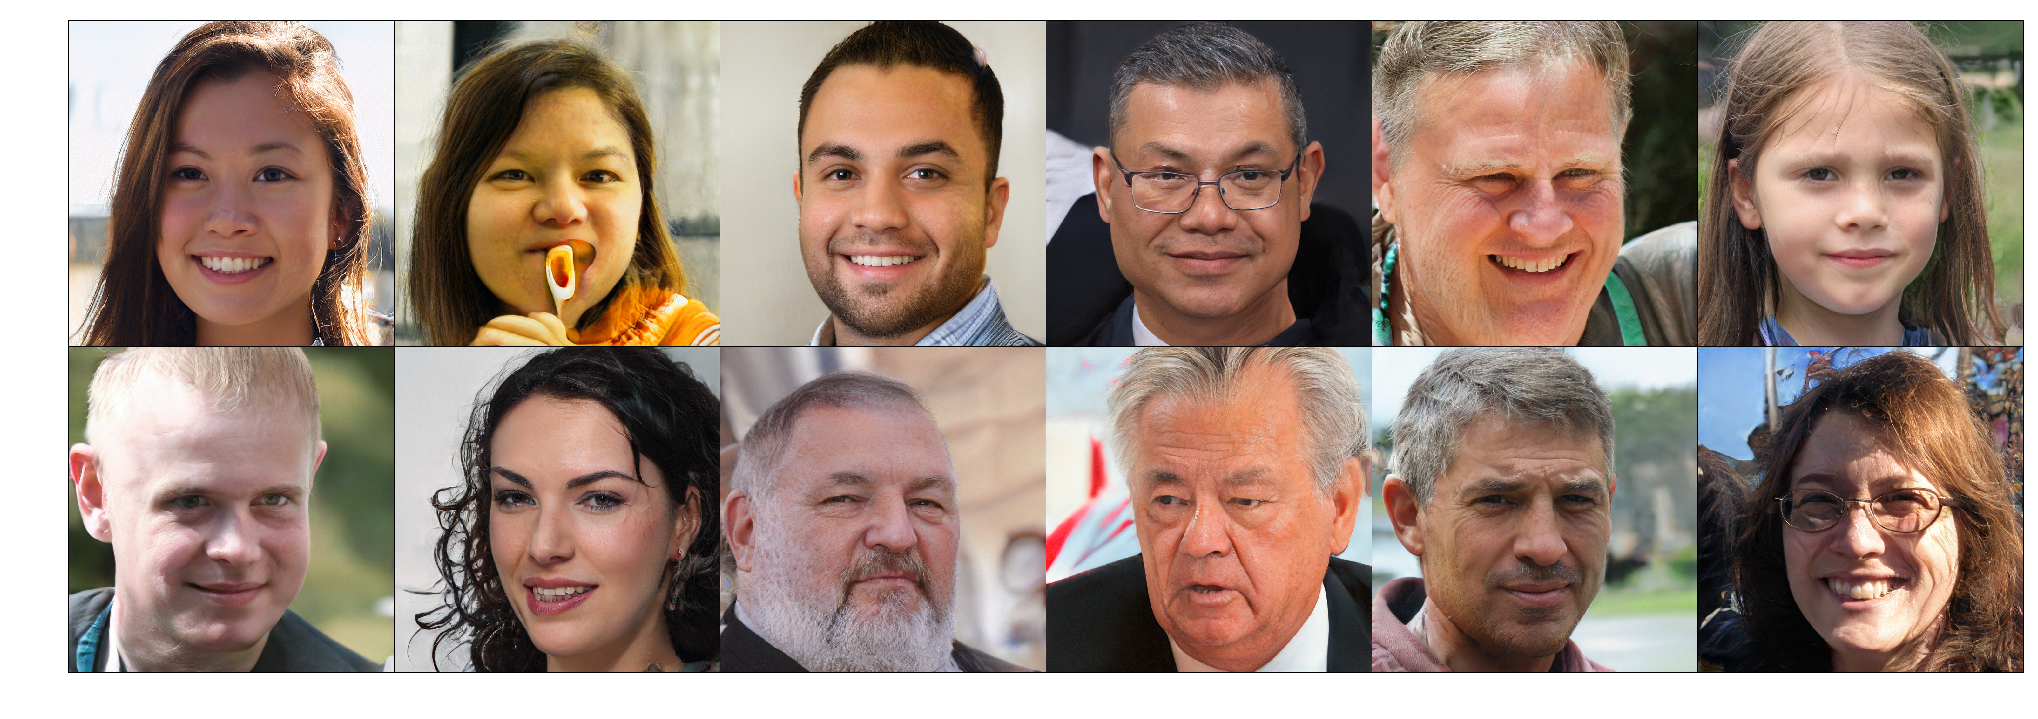

In [83]:
import matplotlib
import matplotlib.pyplot as plt
import torchvision

def plot(images, figsize=(18, 6), nrow=6):
    figure = plt.figure(figsize=figsize)
    images = (images.clamp(-1, 1) + 1.0) / 2
    images = torchvision.utils.make_grid(images.detach().cpu(), nrow=nrow)
    plt.imshow(images.permute(1, 2, 0))
    plt.axis('off');
    
torch.manual_seed(20)
with torch.no_grad():
    plot(generator(torch.randn(12, 512).cuda()))

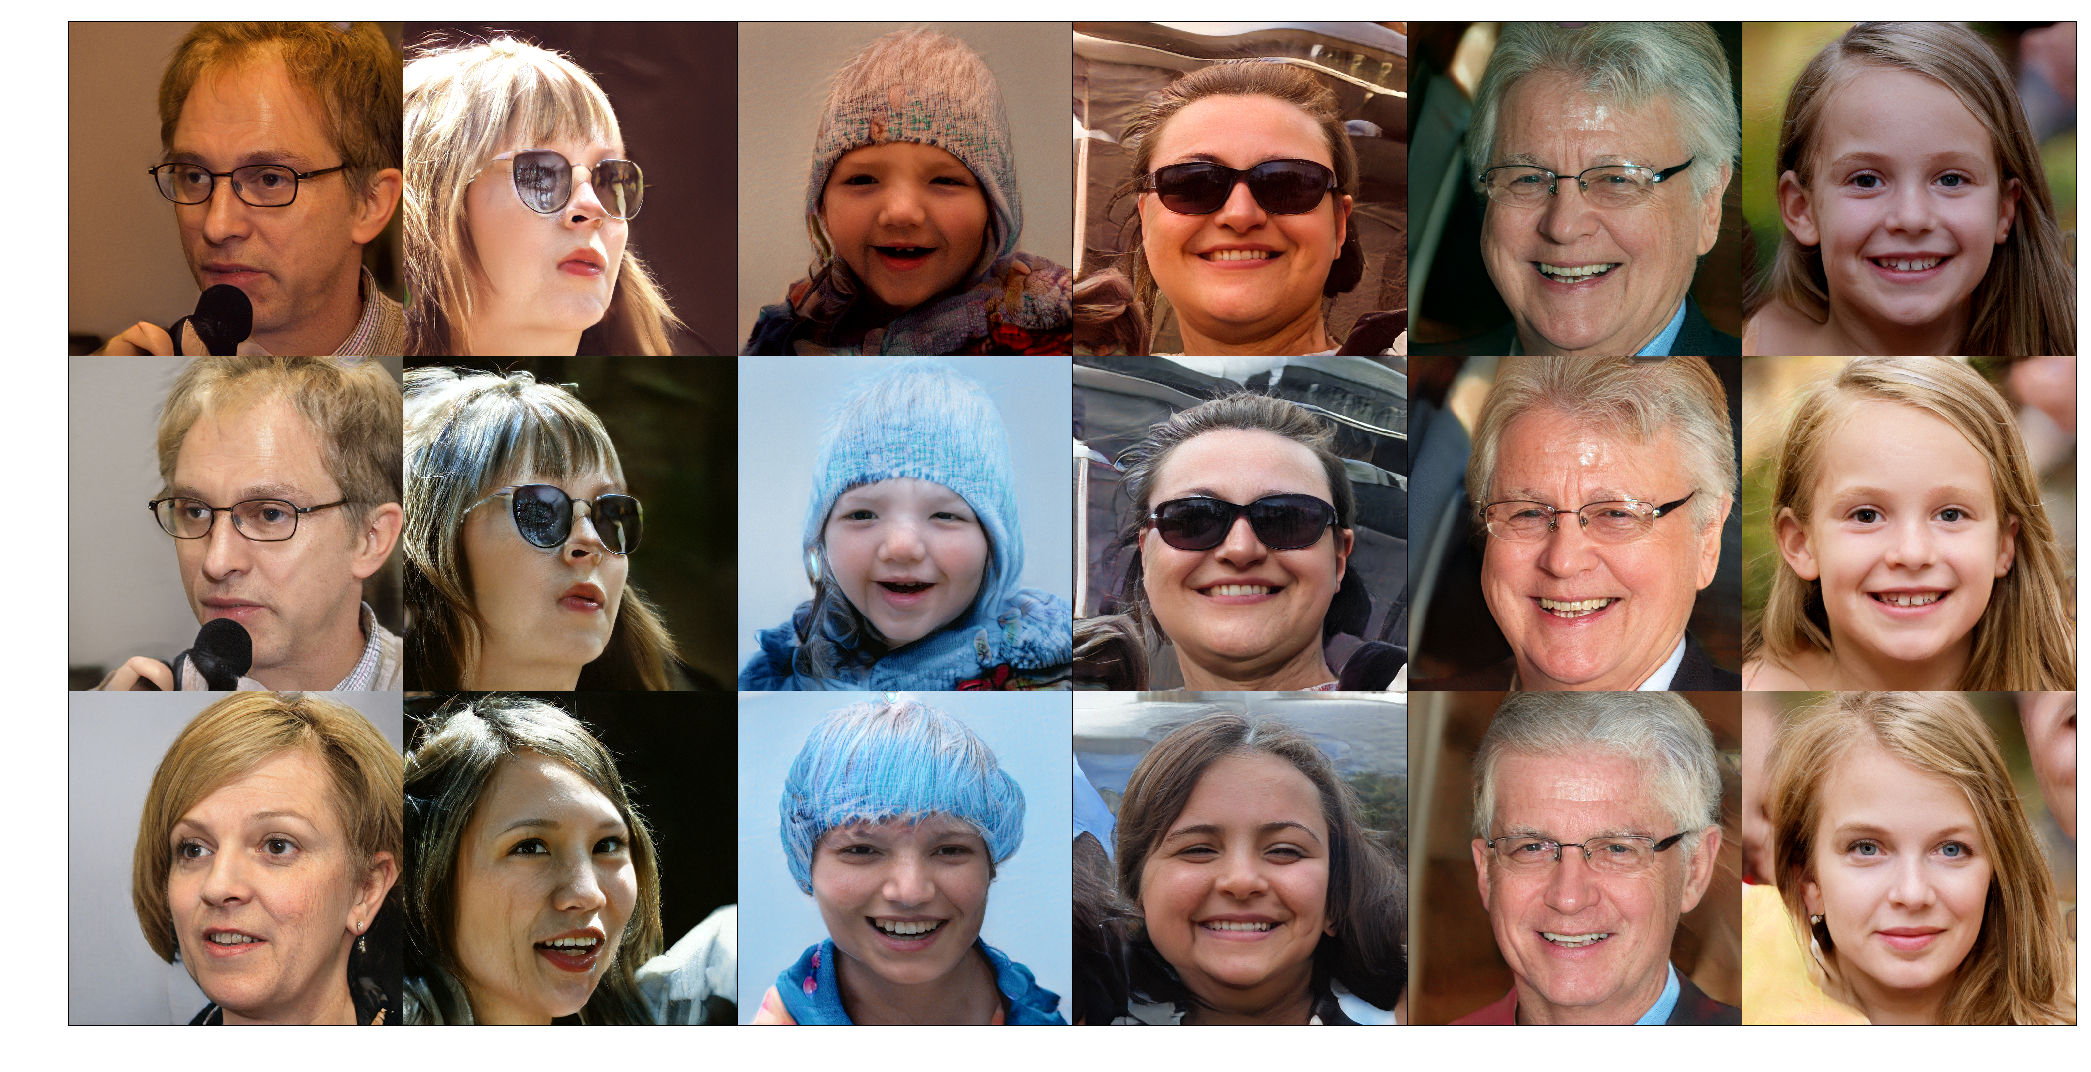

In [120]:
torch.manual_seed(30)
mixed_images = []

# Style mixing
with torch.no_grad():
    src_latents = generator.mapping(torch.randn(6, 512).cuda())
    tgt_latents = generator.mapping(torch.randn(6, 512).cuda())
    for i in [8, 4, 1]:
        latents = src_latents.clone()
        latents[:, 2 * i: 2 * i + 2] = tgt_latents[:, 2 * i: 2 * i + 2]
        mixed_images.append(generator.synthesize(latents))
plot(torch.cat(mixed_images, dim=0), figsize=(18, 18), nrow=6)

In [1]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())